# Mini-batching Graphs
For the next set of examples we will no longer work with a single graph, but with multiple ones. In order to avoid the leakage problem, we will aim to give the model a graph (or subgraph) as it looked at the point in time the payment or transaction as made. For instance let's say that a fraudulent payment occurs from Customer Y to Merchant C on 2/1/2020. Then that edge and node should not be visible before 2/1/2020. 

On 1/1/2020 the model would be seeing the left part of the image, on 2/1/2020, it would be seeing the right part of the image.


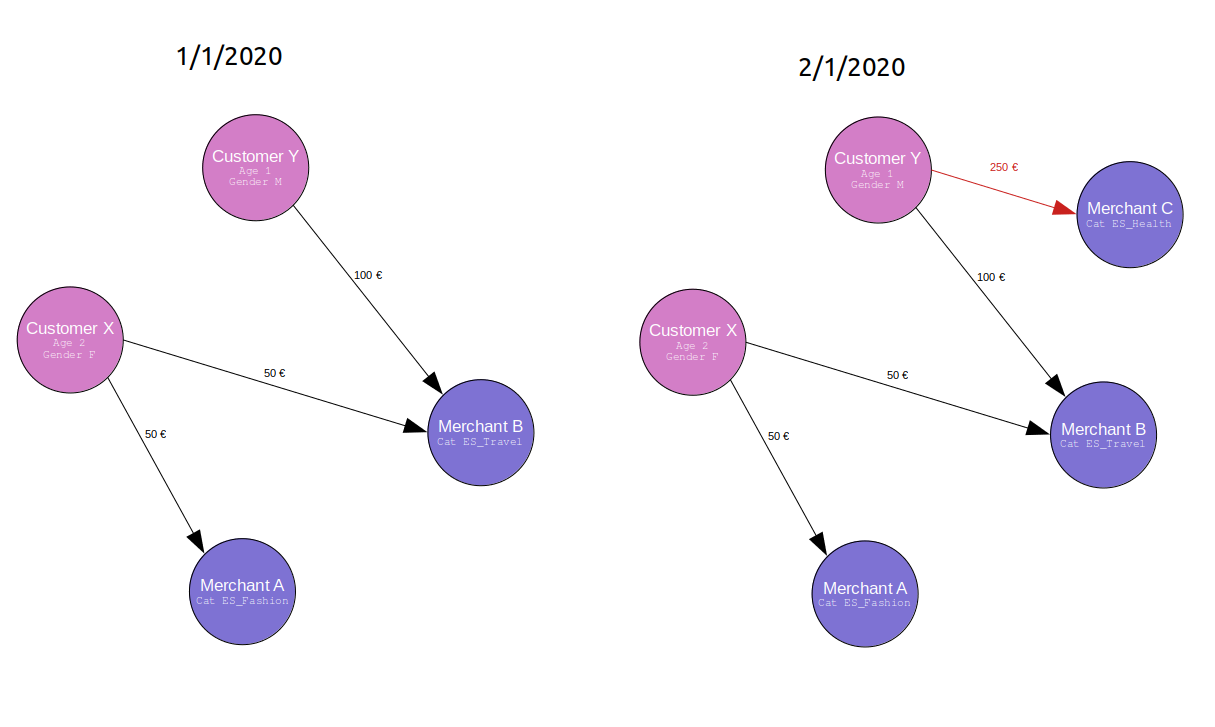

So we would not longer be presenting one massive graph, but various subgraphs. Each showing the neighborhood of a customer at a specific point in time. Ideally we would want to mini-batch the graphs, much like what we did in the series and single data examples.

Mini-batching graphs is a bit different than mini-batching non-graph data, below quickly recaps how a graph is mini-batched.

# Imports

In [11]:
import torch
import numpy as np
import pandas as pd
import gc

import datetime as dt

import d373c7.features as ft
import d373c7.engines as en
import d373c7.pytorch as pt
import d373c7.pytorch.models as pm
import d373c7.plot as pl
import d373c7.network as nw
import d373c7.pytorch.graph.geometric as geo

import torch.nn.functional as F
import torch.nn as nn

from torch_geometric.data import HeteroData
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj, to_networkx
import torch_geometric.transforms as T

import networkx as nx
import matplotlib.pyplot as plt

from torch_geometric.nn import SAGEConv, Linear, HeteroConv

from typing import Tuple

## Define 3 seperate -dummy- graphs. 
They have the same type of nodes and edges, but their layout is different

In [2]:
# Network 1
n1_node1 = torch.as_tensor([1.0, 2.0, 3.0], dtype=torch.float32)
n1_node2 = torch.as_tensor([1.0, 2.0, 3.0, 4.0], dtype=torch.float32)
n1_edge1 = torch.as_tensor([[0.0, 1.0, 2.0], [0.0, 1.0, 2.0]])

# Network 2
n2_node1 = torch.as_tensor([10.0, 20.0, 30.0], dtype=torch.float32)
n2_node2 = torch.as_tensor([10.0, 20.0, 30.0, 40.0], dtype=torch.float32)
n2_edge1 = torch.as_tensor([[0.0, 0.0, 1.0, 2.0], [0.0, 1.0, 1.0, 2.0]])

# Network 3
n3_node1 = torch.as_tensor([100.0, 200.0], dtype=torch.float32)
n3_node2 = torch.as_tensor([300.0, 400.0], dtype=torch.float32)
n3_edge1 = torch.as_tensor([[0.0, 1.0, 1.0], [0.0, 1.0, 0.0]])

In [3]:
g1 = HeteroData({
    'node1': {'x': n1_node1},
    'node2' : {'x': n1_node2},
    ('node1', 'node1_to_node2', 'node2') : {'edge_index': n1_edge1}
})

g2 = HeteroData({
    'node1': {'x': n2_node1},
    'node2' : {'x': n2_node2},
    ('node1', 'node1_to_node2', 'node2') : {'edge_index': n2_edge1}
})
g3 = HeteroData({
    'node1': {'x': n3_node1},
    'node2' : {'x': n3_node2},
    ('node1', 'node1_to_node2', 'node2') : {'edge_index': n3_edge1}
})

In [4]:
g1

HeteroData(
  node1={ x=[3] },
  node2={ x=[4] },
  (node1, node1_to_node2, node2)={ edge_index=[2, 3] }
)

In [5]:
g2

HeteroData(
  node1={ x=[3] },
  node2={ x=[4] },
  (node1, node1_to_node2, node2)={ edge_index=[2, 4] }
)

In [6]:
g3

HeteroData(
  node1={ x=[2] },
  node2={ x=[2] },
  (node1, node1_to_node2, node2)={ edge_index=[2, 3] }
)

## Bundle the graphs into a DataLoader
The batchloader has a batch_size of 3.

In [7]:
dl = DataLoader([g1, g2, g3], batch_size=3)

### Iterate over the batch-loader
Now when we iterage over the loader we can see that it has 'batched' the graphs. A couple of things have happend.
- It's not one big graph again.
- The node feature have be concatenated.
- For each node type a batch tensor has been added showing the id of the original graph. The batch of node1 for instance says [0, 0, 0, 1, 1, 1, 2 ,2]. Meaning the first three nodes belonged to `graph 0`, the next three belonged to `graph 1`, the last two belonged to `graph 2`. We'll need this batch id in the models.
- The egdes have been merged. (See diagram)

In [8]:
for i, e in enumerate(dl): 
    print(f'Batch number {i}')
    print(f'----------------')
    print(e)
    print(f'node 1')
    print(f' \tfeatures: {e["node1"].x}')
    print(f'\tbatch: {e["node1"].batch}')
    print(f'node 2')
    print(f'\tfeatures: {e["node2"].x}')
    print(f'\tbatch: {e["node2"].batch}')
    print(f'egdes')
    print(f'\t{e["node1", "node1_to_node2", "node2"].edge_index}')
    
    print('\n')

Batch number 0
----------------
HeteroDataBatch(
  node1={
    x=[8],
    batch=[8],
    ptr=[4]
  },
  node2={
    x=[10],
    batch=[10],
    ptr=[4]
  },
  (node1, node1_to_node2, node2)={ edge_index=[2, 10] }
)
node 1
 	features: tensor([  1.,   2.,   3.,  10.,  20.,  30., 100., 200.])
	batch: tensor([0, 0, 0, 1, 1, 1, 2, 2])
node 2
	features: tensor([  1.,   2.,   3.,   4.,  10.,  20.,  30.,  40., 300., 400.])
	batch: tensor([0, 0, 0, 0, 1, 1, 1, 1, 2, 2])
egdes
	tensor([[0., 1., 2., 3., 3., 4., 5., 6., 7., 7.],
        [0., 1., 2., 4., 5., 5., 6., 8., 9., 8.]])




The way the edges have been re-ordered is worth noting. One big adjacency matrix has been made where the graphs are not-interconnected (no messages can flow between the original graphs). If the adjacency matrices were dense they the conversion would look like depicted below 

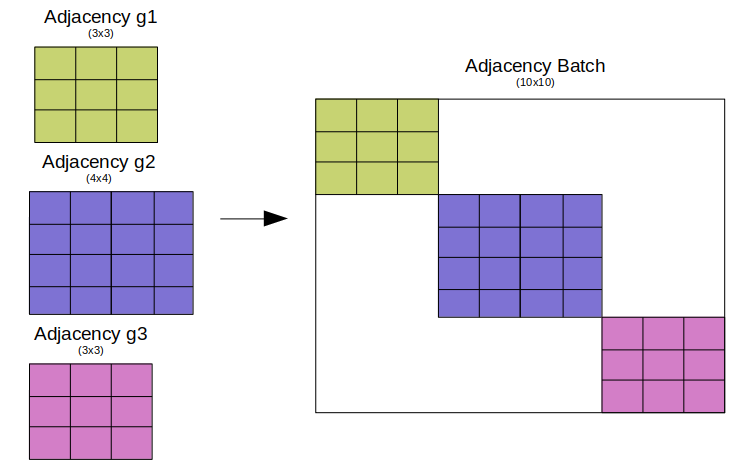